In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Conv1D

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
df_distinct_stacks['listStackTrace'] = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.split('\n'))
corpus = df_distinct_stacks['listStackTrace'].tolist()
frames = pd.Series(list(set([elt for l in corpus for elt in l])))
df_frames = pd.DataFrame()
df_frames['frame'] = pd.get_dummies(frames).T.reset_index().rename(columns={'index': 'frame'})['frame']
df_frames['embedding'] = pd.get_dummies(frames).T.reset_index().apply(lambda x : x[1:].values, axis = 1)
df_distinct_stacks['rankFrames'] = df_distinct_stacks['listStackTrace'].apply(lambda x : index_frame(x, df_frames))

In [7]:
df_levenshtein = pd.DataFrame()
df_levenshtein['Levensh'] = df_measures['Levensh']
df_levenshtein['stack1'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[0], axis = 1)
df_levenshtein['stack2'] = df_levenshtein.apply(lambda x : assign_stacks(rowIndex(x), df_distinct_stacks)[1], axis = 1)

In [8]:
embeddings = 1 * np.random.randn(df_frames.shape[0] + 1, df_frames['embedding'][0].shape[0])
embeddings[0] = 0
embeddings[1:] = np.vstack(df_frames['embedding'].tolist())
embeddings.shape

(2251, 2250)

In [9]:
X = df_levenshtein[['stack1','stack2']]
Y = df_levenshtein['Levensh']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2)

max_length = df_distinct_stacks['listStackTrace'].apply(lambda x : len(x)).max()
X_train = padding(X_train, max_length)
X_validation = padding(X_validation, max_length)

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

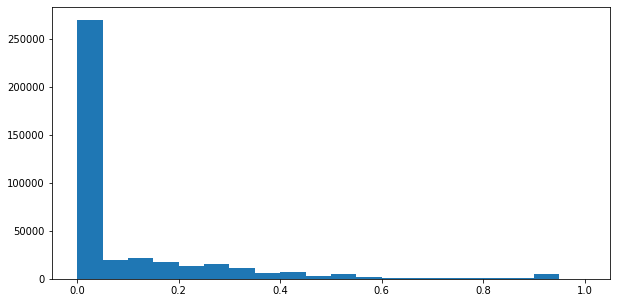

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

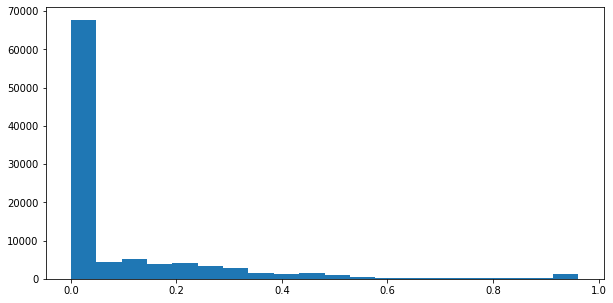

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

<div>
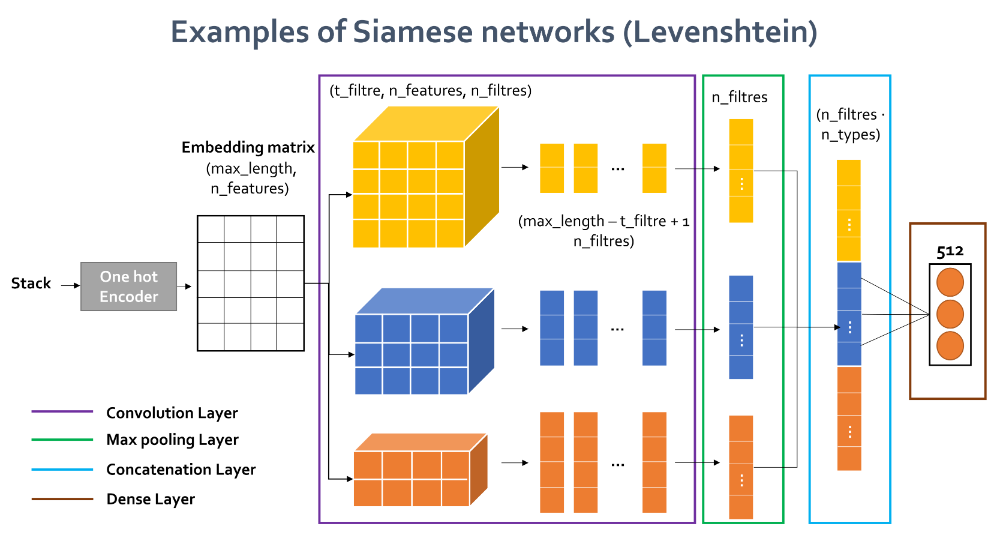
<div>

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
input_tensor = Input(shape = (max_length,))
input_layer = (Embedding(len(embeddings), df_frames.shape[0], weights=[embeddings], input_shape=(max_length,), trainable=False))(input_tensor)
submodels = []
for kw in (3,4) :
    conv_layer = Conv1D(1024, kw, activation='tanh')(input_layer)
    maxpool_layer = GlobalMaxPooling1D()(conv_layer)
    submodels.append(maxpool_layer)
conc_layer = concatenate(submodels, axis=1)
dense_layer = Dense(size_hash_vector, activation = 'tanh')(conc_layer)
x = Sequential()
x.add(Model(inputs = input_tensor, outputs = dense_layer))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (max_length,)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = False, print_summary = False)

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 440s 551ms/step - loss: 0.0206 - ham_dist_loss: 0.0208 - prod_vec_loss: 0.0360 - prod_vec_1_loss: 0.0355 - sum_vec_loss: 1.6833e-04 - sum_vec_1_loss: 1.6677e-04 - ham_dist_rmse: 0.1441 - ham_dist_mae: 0.0564 - val_loss: 0.0018 - val_ham_dist_loss: 0.0018 - val_prod_vec_loss: 0.0050 - val_prod_vec_1_loss: 0.0046 - val_sum_vec_loss: 1.1641e-04 - val_sum_vec_1_loss: 1.1842e-04 - val_ham_dist_rmse: 0.0422 - val_ham_dist_mae: 0.0203
Epoch 2/20
781/781 [==============================] - 432s 553ms/step - loss: 0.0013 - ham_dist_loss: 0.0012 - prod_vec_loss: 0.0036 - prod_vec_1_loss: 0.0033 - sum_vec_loss: 1.0355e-04 - sum_vec_1_loss: 1.0577e-04 - ham_dist_rmse: 0.0349 - ham_dist_mae: 0.0166 - val_loss: 0.0010 - val_ham_dist_loss: 0.0010 - val_prod_vec_loss: 0.0026 - val_prod_vec_1_loss: 0.0024 - val_sum_vec_loss: 8.9253e-05 - val_sum_vec_1_loss: 8.7614e-05 - val_ham_dist_rmse: 0.0321 - val_ham_dist_mae: 0.0148
Epoch 3/20
781/781 [========

# 3. Model Evaluation

In [22]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

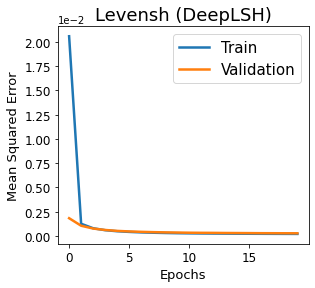

In [25]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Levensh (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

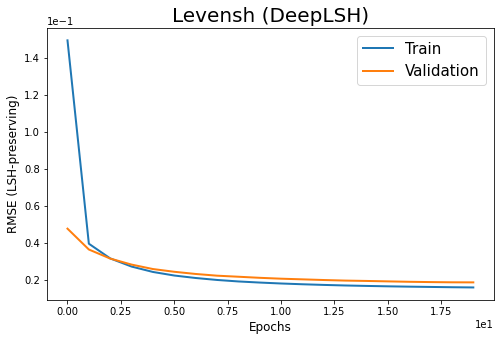

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Levensh (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

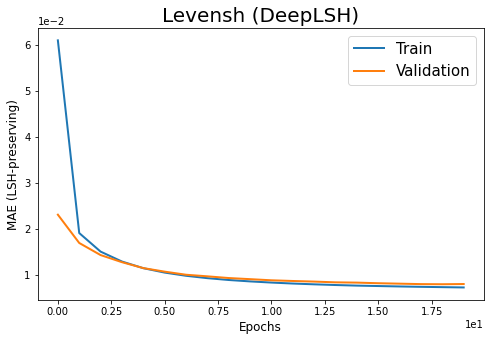

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Levensh (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.31 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.014, 0.173,
       0.352, 0.211, 0.   , 0.   , 0.264, 0.339, 0.   , 0.   , 0.245,
       0.   , 0.   , 0.   , 0.663, 0.868, 0.362, 0.001, 0.   , 0.   ,
       0.343, 0.   , 0.004, 0.   , 0.306, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.277, 0.   , 0.   , 0.   , 0.03 , 0.   , 0.054, 0.   ,
       0.   , 0.172, 0.238, 0.001, 0.   ], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.312, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.16 ,
       0.409, 0.217, 0.   , 0.   , 0.263, 0.368, 0.   , 0.   , 0.25 ,
       0.   , 0.   , 0.   , 0.688, 0.824, 0.389, 0.   , 0.   , 0.   ,
       0.421, 0.   , 0.   , 0.   , 0.286, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.278, 0.   , 0.   , 0.   , 0.   , 0.   , 0.048, 0.   ,
       0.   , 0.158, 0.192, 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

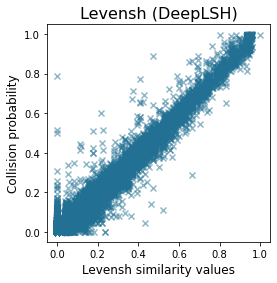

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.xlabel("Levensh similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Levensh-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.8459273643029578

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.7392502129424708

## 3.3. Approximate Hamming Evaluation

In [31]:
output_layer = 0
model.layers[output_layer]

In [35]:
intermediate_model = intermediate_model_trained(shared_model, output_layer, True, input_tensor)

In [40]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [ ]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [36]:
intermediate_model.predict(padding(X.iloc[[11]], max_length)['stack_1'])[0][:32]

array([-0.9995453 , -0.99997425, -0.9995537 ,  1.        ,  1.        ,
       -0.99961674, -1.        ,  0.99957186, -1.        ,  0.99960005,
       -0.9995383 , -0.99994534,  0.9994737 , -0.9995072 , -1.        ,
       -0.99977994,  1.        ,  1.        ,  0.99999934,  0.99957144,
       -0.99928826, -1.        ,  1.        ,  0.9994518 , -0.99953   ,
       -0.99939966,  0.99954325, -0.9995986 , -1.        ,  0.9999894 ,
       -0.99999845, -1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [37]:
hash_vectors = intermediate_model.predict(pad_sequences(df_distinct_stacks['rankFrames'], padding = 'post', truncating = 'post', maxlen = 29)) 

In [38]:
np.mean(np.abs(hash_vectors))

0.99590415

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [39]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.3188642578125

### 3.3.4. Comparison between approximate hamming and real hamming

In [41]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

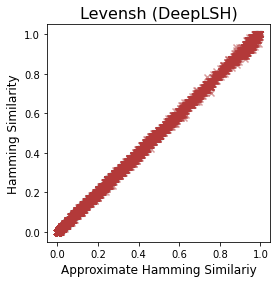

In [42]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Levensh (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Levensh-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [43]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [44]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


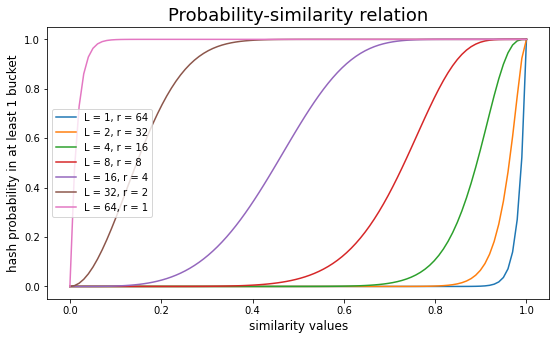

In [45]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [46]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Levensh', trace = False)

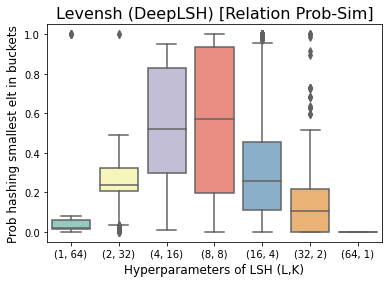

In [47]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Levensh (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Levensh-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [48]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [49]:
df_probLSH.mean()['(4, 16)']

0.5438453834504193

In [50]:
df_probLSH.median()['(4, 16)']

0.5224454705157258

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [51]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [52]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [65]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

424

In [66]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{180, 289, 424, 445, 735, 812, 853, 857, 888, 977}

In [67]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [68]:
near_duplicates_sim = df_measures['Levensh'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

247229    0.937500
334287    0.875000
163953    0.875000
334328    0.875000
334363    0.875000
334332    0.875000
334452    0.823529
333920    0.823529
334210    0.823529
Name: Levensh, dtype: float64

In [69]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Levensh', n_stacks, n_duplicate_pairs)
set_real_nns

{180, 289, 445, 468, 812, 853, 857, 888, 921}

In [70]:
real_nns_sim[:n_duplicate_pairs]

333943    0.941176
247229    0.937500
334287    0.875000
163953    0.875000
334328    0.875000
334363    0.875000
334332    0.875000
334396    0.823529
333920    0.823529
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [71]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.889

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [72]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.9029999999999992

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

-----------------------------------------------------------------

In [73]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

0.9209999999999988

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Levensh')

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [74]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.9228395061728395

In [75]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Levensh', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.990079
(2, 32)    0.972343
(4, 16)    0.968308
(8, 8)     0.951015
(16, 4)    0.902248
(32, 2)    0.930149
(64, 1)    0.999040
dtype: float64

In [77]:
df_knns.mean(skipna = True, axis = 0)['(8, 8)']

0.9510154578420222